# Problem Definition

## Background
Energy consumption significantly impacts both household finances and global carbon emissions. While current energy monitoring systems can track and forecast electricity usage, they have notable limitations in their approach.

## Key Challenges
### 1. Dynamic Tariff Rates
- Electricity costs fluctuate throughout the day
- Peak vs off-peak pricing affects total costs
- Current systems rarely account for these variations

### 2. Carbon Intensity Variations
- Environmental impact per kWh is not constant
- Depends on energy source:
  - Renewable (solar, wind): Lower carbon intensity
  - Fossil fuels (coal, gas): Higher carbon intensity
  - Mix varies by time and location

## Current Gap
Consumers and organizations lack the tools to make decisions that optimize both:
- Energy costs
- Carbon footprint

## Core Problem Statement
There is a critical need for an integrated prediction model that combines:
- Electricity usage patterns
- Dynamic tariff structures
- Real-time CO₂ emission factors

This gap prevents effective decision-making for sustainable and cost-efficient energy consumption.


## 1. Import Libraries and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

## 2. Data Loading and Preprocessing

In [3]:
def load_and_preprocess_data():
    """Load and preprocess the carbon emission dataset"""
    print("Loading dataset...")
    
    # Load data in chunks to handle large file
    chunk_size = 100000
    chunks = []
    
    for chunk in pd.read_csv('total_dataset.csv', chunksize=chunk_size):
        chunks.append(chunk)
    
    df = pd.concat(chunks, ignore_index=True)
    print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
    
    # Basic info
    print("\n=== DATASET INFO ===")
    print(df.info())
    print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Rename columns for easier handling
    df.columns = ['timestamp', 'kwh', 'voltage', 'current', 'frequency', 'meter']
    
    # Convert timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Extract time features
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_name'] = df['timestamp'].dt.day_name()
    
    return df

# Load the data
df = load_and_preprocess_data()
df.head()

Loading dataset...
Dataset loaded: 14,767,069 rows, 6 columns

=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14767069 entries, 0 to 14767068
Data columns (total 6 columns):
 #   Column                Dtype  
---  ------                -----  
 0   x_Timestamp           object 
 1   t_kWh                 float64
 2   z_Avg Voltage (Volt)  float64
 3   z_Avg Current (Amp)   float64
 4   y_Freq (Hz)           float64
 5   meter                 object 
dtypes: float64(4), object(2)
memory usage: 676.0+ MB
None

Memory usage: 2154.70 MB


,timestamp,kwh,voltage,current,frequency,meter,year,month,day,hour,minute,day_of_week,day_name
0,2021-01-02 00:00:00,0.002,253.36,0.25,50.09,BR02,2021,1,2,0,0,5,Saturday
1,2021-01-02 00:03:00,0.002,253.87,0.25,50.11,BR02,2021,1,2,0,3,5,Saturday
2,2021-01-02 00:06:00,0.020,253.25,1.67,50.14,BR02,2021,1,2,0,6,5,Saturday
3,2021-01-02 00:09:00,0.045,252.20,3.52,50.12,BR02,2021,1,2,0,9,5,Saturday
4,2021-01-02 00:12:00,0.044,252.28,3.53,50.07,BR02,2021,1,2,0,12,5,Saturday


## 3. Basic Statistics

In [20]:
print("=== BASIC STATISTICS ===")
display(df.describe())

=== BASIC STATISTICS ===


,timestamp,kwh,voltage,current,frequency,year,month,day,hour,minute,day_of_week
count,14767069,1.476707e+07,1.476707e+07,1.476707e+07,1.476707e+07,1.476707e+07,1.476707e+07,1.476707e+07,1.476707e+07,1.476707e+07,1.476707e+07
mean,2020-05-31 04:34:51.071300352,1.723107e-02,2.216273e+02,1.636982e+00,4.565875e+01,2.019864e+03,7.107662e+00,1.578913e+01,1.149992e+01,2.850010e+01,3.010224e+00
min,2019-05-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2019-10-08 02:42:00,3.000000e-03,2.298600e+02,2.900000e-01,4.996000e+01,2.019000e+03,5.000000e+00,8.000000e+00,6.000000e+00,1.500000e+01,1.000000e+00
50%,2020-03-20 15:57:00,9.000000e-03,2.436400e+02,9.400000e-01,5.000000e+01,2.020000e+03,8.000000e+00,1.600000e+01,1.100000e+01,3.000000e+01,3.000000e+00
75%,2021-01-31 14:24:00,2.000000e-02,2.535100e+02,2.010000e+00,5.004000e+01,2.021000e+03,1.000000e+01,2.300000e+01,1.700000e+01,4.500000e+01,5.000000e+00
max,2021-10-31 23:57:00,3.000000e-01,6.547300e+02,1.260500e+02,5.703300e+02,2.021000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.700000e+01,6.000000e+00
std,NaN,2.501600e-02,7.059557e+01,2.222125e+00,1.408451e+01,8.525963e-01,3.365234e+00,8.750772e+00,6.921473e+00,1.729893e+01,2.003423e+00


In [4]:
print("=== MISSING VALUES ===")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
display(missing_df[missing_df['Missing Count'] > 0])

=== MISSING VALUES ===


,Missing Count,Percentage


In [5]:
print("=== UNIQUE VALUES ===")
for col in df.columns:
    if df[col].dtype == 'object' or col == 'meter':
        print(f"{col}: {df[col].nunique()} unique values")

print(f"\nUnique meters: {df['meter'].unique()}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

=== UNIQUE VALUES ===
meter: 84 unique values
day_name: 7 unique values

Unique meters: ['BR02' 'BR04' 'BR05' 'BR06' 'BR08' 'BR09' 'BR11' 'BR12' 'BR13' 'BR15'
 'BR16' 'BR18' 'BR19' 'BR22' 'BR24' 'BR27' 'BR28' 'BR29' 'BR30' 'BR31'
 'BR32' 'BR33' 'BR34' 'BR35' 'BR36' 'BR37' 'BR38' 'BR39' 'BR42' 'BR43'
 'BR44' 'BR45' 'BR46' 'BR48' 'BR49' 'BR50' 'BR51' 'BR52' 'MH01' 'MH02'
 'MH03' 'MH06' 'MH07' 'MH08' 'MH09' 'MH10' 'MH11' 'MH12' 'MH14' 'MH15'
 'MH17' 'MH18' 'MH20' 'MH21' 'MH22' 'MH23' 'MH24' 'MH25' 'MH26' 'MH27'
 'MH28' 'MH30' 'MH31' 'MH33' 'MH34' 'MH35' 'MH36' 'MH37' 'MH38' 'MH39'
 'MH41' 'MH42' 'MH43' 'MH45' 'MH46' 'MH47' 'BR03' 'BR07' 'BR10' 'BR14'
 'BR17' 'BR20' 'BR23' 'BR26']
Date range: 2019-05-01 00:00:00 to 2021-10-31 23:57:00


## 4. Data Quality Checks

In [6]:
print("=== DATA QUALITY CHECKS ===")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates:,}")

# Check for negative values
numeric_cols = ['kwh', 'voltage', 'current', 'frequency']
for col in numeric_cols:
    negative = (df[col] < 0).sum()
    if negative > 0:
        print(f"Negative values in {col}: {negative:,}")

=== DATA QUALITY CHECKS ===
Duplicate rows: 0


In [7]:
# Check for outliers using IQR
print("=== OUTLIER DETECTION (IQR Method) ===")
outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_pct = outliers/len(df)*100
    outlier_summary.append({'Column': col, 'Outliers': outliers, 'Percentage': f"{outlier_pct:.2f}%"})
    print(f"{col}: {outliers:,} outliers ({outlier_pct:.2f}%)")

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

=== OUTLIER DETECTION (IQR Method) ===
kwh: 1,230,230 outliers (8.33%)
voltage: 1,637,145 outliers (11.09%)
current: 1,151,682 outliers (7.80%)
frequency: 1,509,365 outliers (10.22%)


,Column,Outliers,Percentage
0,kwh,1230230,8.33%
1,voltage,1637145,11.09%
2,current,1151682,7.80%
3,frequency,1509365,10.22%


## 5. Data Cleaning

In [8]:
def clean_data(df):
    """Clean the dataset"""
    print("=== DATA CLEANING ===")
    
    initial_rows = len(df)
    
    # Remove duplicates
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - len(df):,} duplicate rows")
    
    # Remove negative values (if any)
    numeric_cols = ['kwh', 'voltage', 'current', 'frequency']
    for col in numeric_cols:
        before = len(df)
        df = df[df[col] >= 0]
        removed = before - len(df)
        if removed > 0:
            print(f"Removed {removed:,} rows with negative {col}")
    
    # Remove extreme outliers (beyond 3 standard deviations)
    for col in numeric_cols:
        before = len(df)
        mean_val = df[col].mean()
        std_val = df[col].std()
        df = df[abs(df[col] - mean_val) <= 3 * std_val]
        removed = before - len(df)
        if removed > 0:
            print(f"Removed {removed:,} extreme outliers from {col}")
    
    print(f"Final dataset size: {len(df):,} rows")
    return df

# Clean the data
df_clean = clean_data(df)

=== DATA CLEANING ===
Removed 0 duplicate rows
Removed 474,891 extreme outliers from kwh
Removed 1,282,882 extreme outliers from voltage
Removed 356,536 extreme outliers from current
Removed 3,830 extreme outliers from frequency
Final dataset size: 12,648,930 rows


## 6. Temporal Analysis

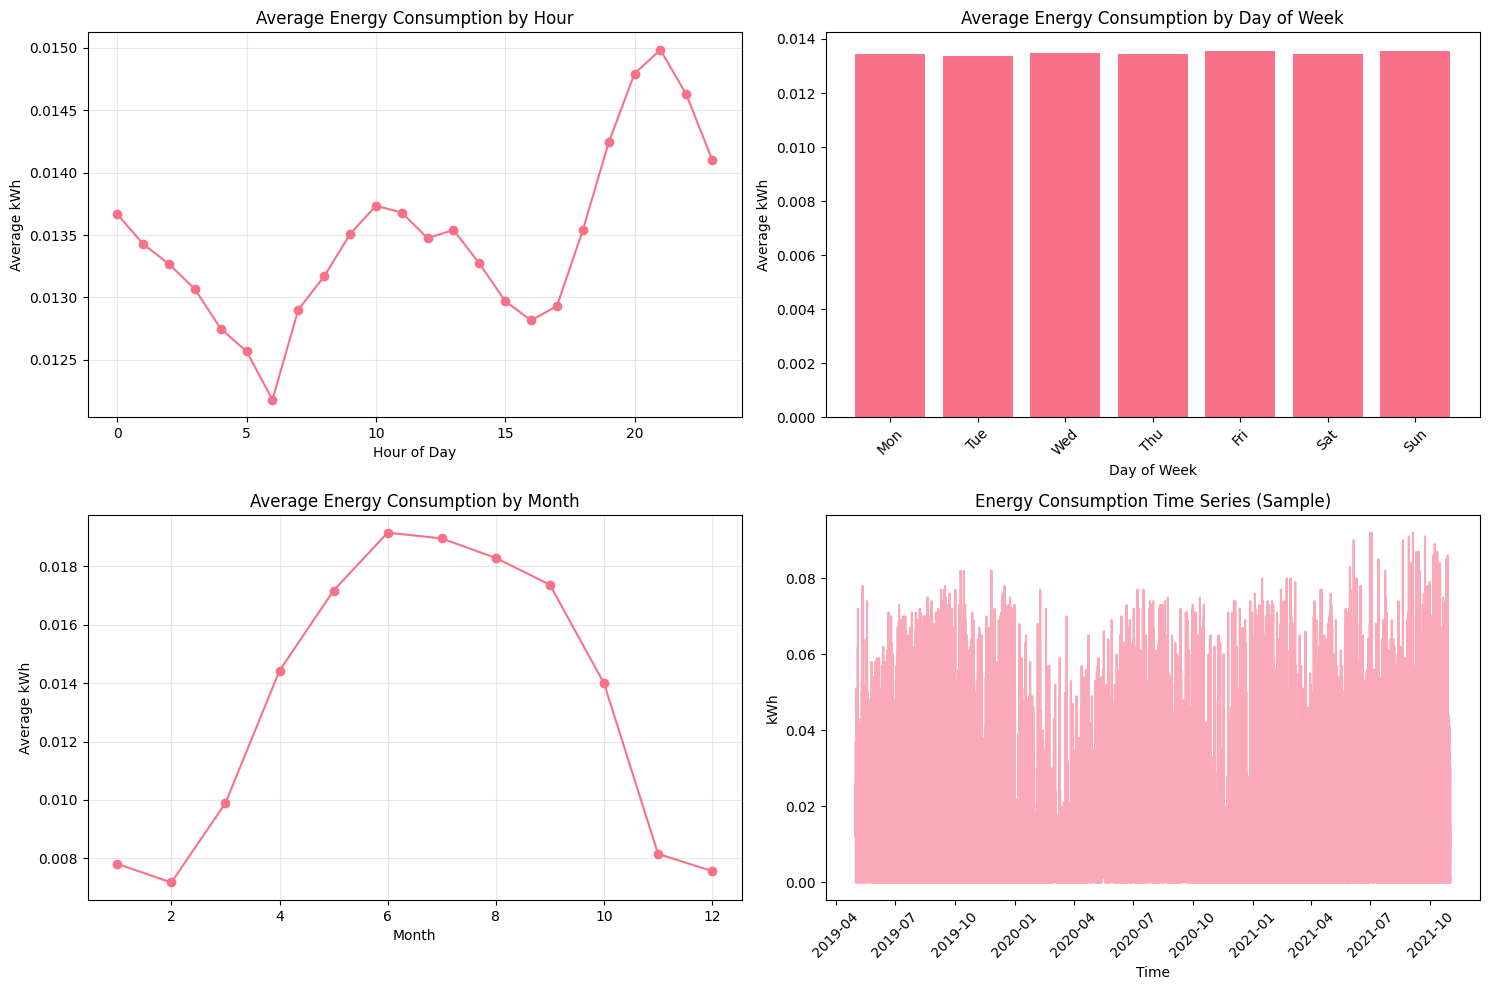

In [9]:
# Sample data for visualization (to handle large dataset)
sample_size = min(50000, len(df_clean))
df_sample = df_clean.sample(n=sample_size, random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Energy consumption by hour
hourly_consumption = df_clean.groupby('hour')['kwh'].mean()
axes[0,0].plot(hourly_consumption.index, hourly_consumption.values, marker='o')
axes[0,0].set_title('Average Energy Consumption by Hour')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Average kWh')
axes[0,0].grid(True, alpha=0.3)

# Energy consumption by day of week
daily_consumption = df_clean.groupby('day_name')['kwh'].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_consumption = daily_consumption.reindex(day_order)
axes[0,1].bar(range(len(daily_consumption)), daily_consumption.values)
axes[0,1].set_title('Average Energy Consumption by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Average kWh')
axes[0,1].set_xticks(range(len(day_order)))
axes[0,1].set_xticklabels([d[:3] for d in day_order], rotation=45)

# Monthly consumption
monthly_consumption = df_clean.groupby('month')['kwh'].mean()
axes[1,0].plot(monthly_consumption.index, monthly_consumption.values, marker='o')
axes[1,0].set_title('Average Energy Consumption by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average kWh')
axes[1,0].grid(True, alpha=0.3)

# Time series plot (sample)
df_sample_sorted = df_sample.sort_values('timestamp')
axes[1,1].plot(df_sample_sorted['timestamp'], df_sample_sorted['kwh'], alpha=0.6)
axes[1,1].set_title('Energy Consumption Time Series (Sample)')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('kWh')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Feature Engineering and Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Create a copy for feature engineering
df_features = df_clean.copy()

# Encode categorical variables
label_encoder = LabelEncoder()

# Encode meter column
df_features['meter_encoded'] = label_encoder.fit_transform(df_features['meter'])

# Encode day_name column
df_features['day_name_encoded'] = label_encoder.fit_transform(df_features['day_name'])

# Create cyclical features for time-based columns
import numpy as np

# Hour cyclical encoding
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)

# Day of week cyclical encoding
df_features['day_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
df_features['day_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)

# Month cyclical encoding
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

print("Feature engineering completed!")
print(f"Dataset shape after encoding: {df_features.shape}")

## 8. Data Splitting

In [ ]:
# Select features for modeling
feature_columns = [
    'voltage', 'current', 'frequency',
    'year', 'month', 'day', 'hour', 'minute',
    'day_of_week', 'meter_encoded', 'day_name_encoded',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'month_sin', 'month_cos'
]

# Prepare features and target
X = df_features[feature_columns]
y = df_features['kwh']

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

# Further split training data for validation (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Data splitting completed!")
print(f"Training set: {X_train_final.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

## 9. Feature Scaling

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform all sets
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns)

print("Feature scaling completed!")
print(f"Features used: {len(feature_columns)}")
print(f"Feature names: {feature_columns}")

## 10. Correlation Analysis

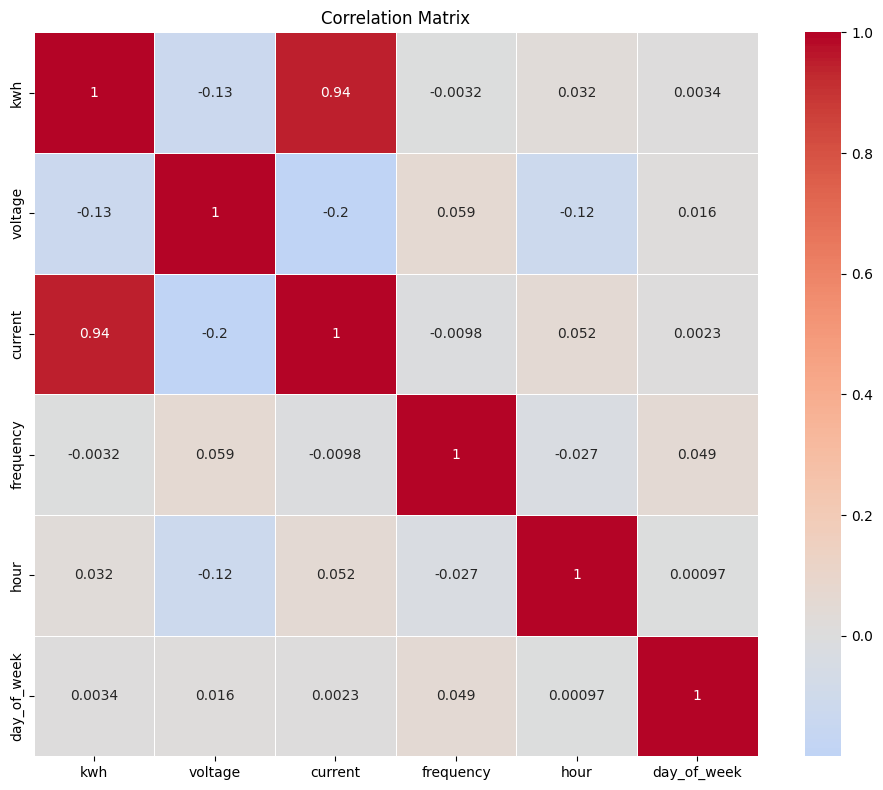

Correlation with kWh:


kwh            1.000000
current        0.944898
hour           0.031738
day_of_week    0.003422
frequency     -0.003223
voltage       -0.128231
Name: kwh, dtype: float64

In [27]:
numeric_cols = ['kwh', 'voltage', 'current', 'frequency', 'hour', 'day_of_week']
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("Correlation with kWh:")
kwh_corr = corr_matrix['kwh'].sort_values(ascending=False)
display(kwh_corr)

## 11. Meter Analysis

In [28]:
meter_stats = df_clean.groupby('meter').agg({
    'kwh': ['count', 'mean', 'std', 'sum'],
    'voltage': 'mean',
    'current': 'mean',
    'frequency': 'mean'
}).round(4)

print("Statistics by Meter:")
display(meter_stats)

Statistics by Meter:


kwh                             voltage current frequency
        count    mean     std       sum      mean    mean      mean
meter                                                              
BR02    86410  0.0089  0.0095   770.050  250.8441  0.8636   50.0052
BR03    61669  0.0140  0.0095   862.743  247.7567  1.3389   50.0069
BR04   187800  0.0202  0.0146  3794.440  243.6786  1.9749   50.0025
BR05   100882  0.0057  0.0054   570.159  246.3529  0.6442   50.0021
BR06   175185  0.0222  0.0136  3887.086  245.3472  2.1710   50.0019
...       ...     ...     ...       ...       ...     ...       ...
MH42   193310  0.0160  0.0098  3086.251  245.2255  1.6218   50.0031
MH43   257124  0.0189  0.0158  4852.602  247.1987  1.7452   50.0040
MH45   162857  0.0146  0.0125  2378.488  246.2507  1.6312   50.0057
MH46   187416  0.0114  0.0104  2141.398  249.1867  1.1809   50.0029
MH47   182255  0.0041  0.0048   738.733  248.7294  0.3677   50.0034

[84 rows x 7 columns]

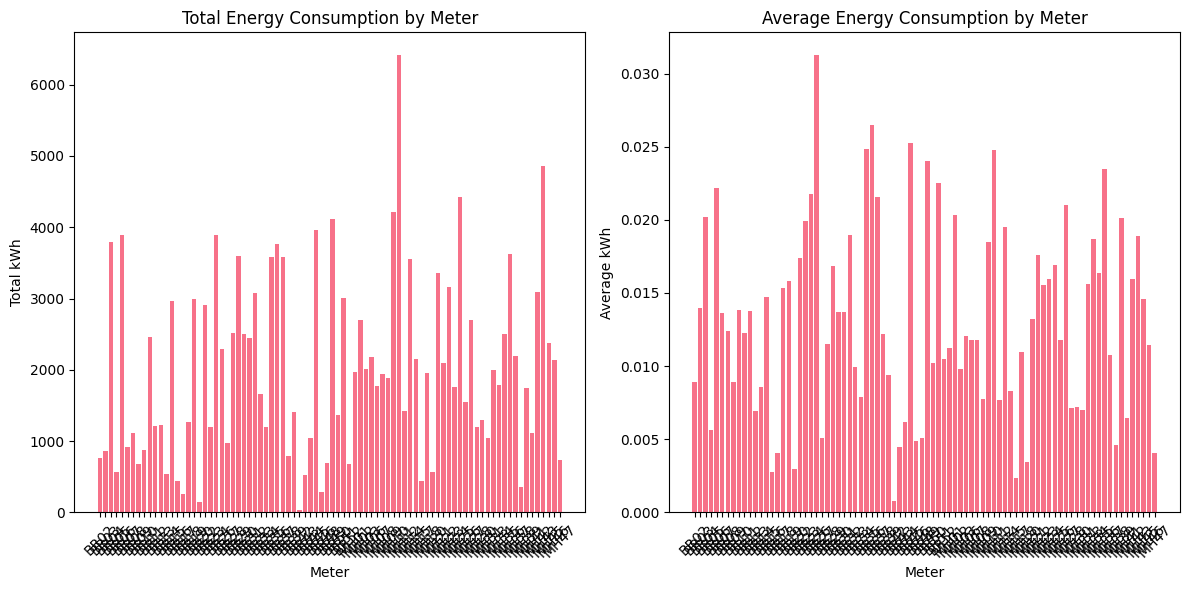

In [29]:
# Visualize consumption by meter
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
meter_consumption = df_clean.groupby('meter')['kwh'].sum()
plt.bar(meter_consumption.index, meter_consumption.values)
plt.title('Total Energy Consumption by Meter')
plt.xlabel('Meter')
plt.ylabel('Total kWh')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
meter_avg = df_clean.groupby('meter')['kwh'].mean()
plt.bar(meter_avg.index, meter_avg.values)
plt.title('Average Energy Consumption by Meter')
plt.xlabel('Meter')
plt.ylabel('Average kWh')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 12. Distribution Analysis

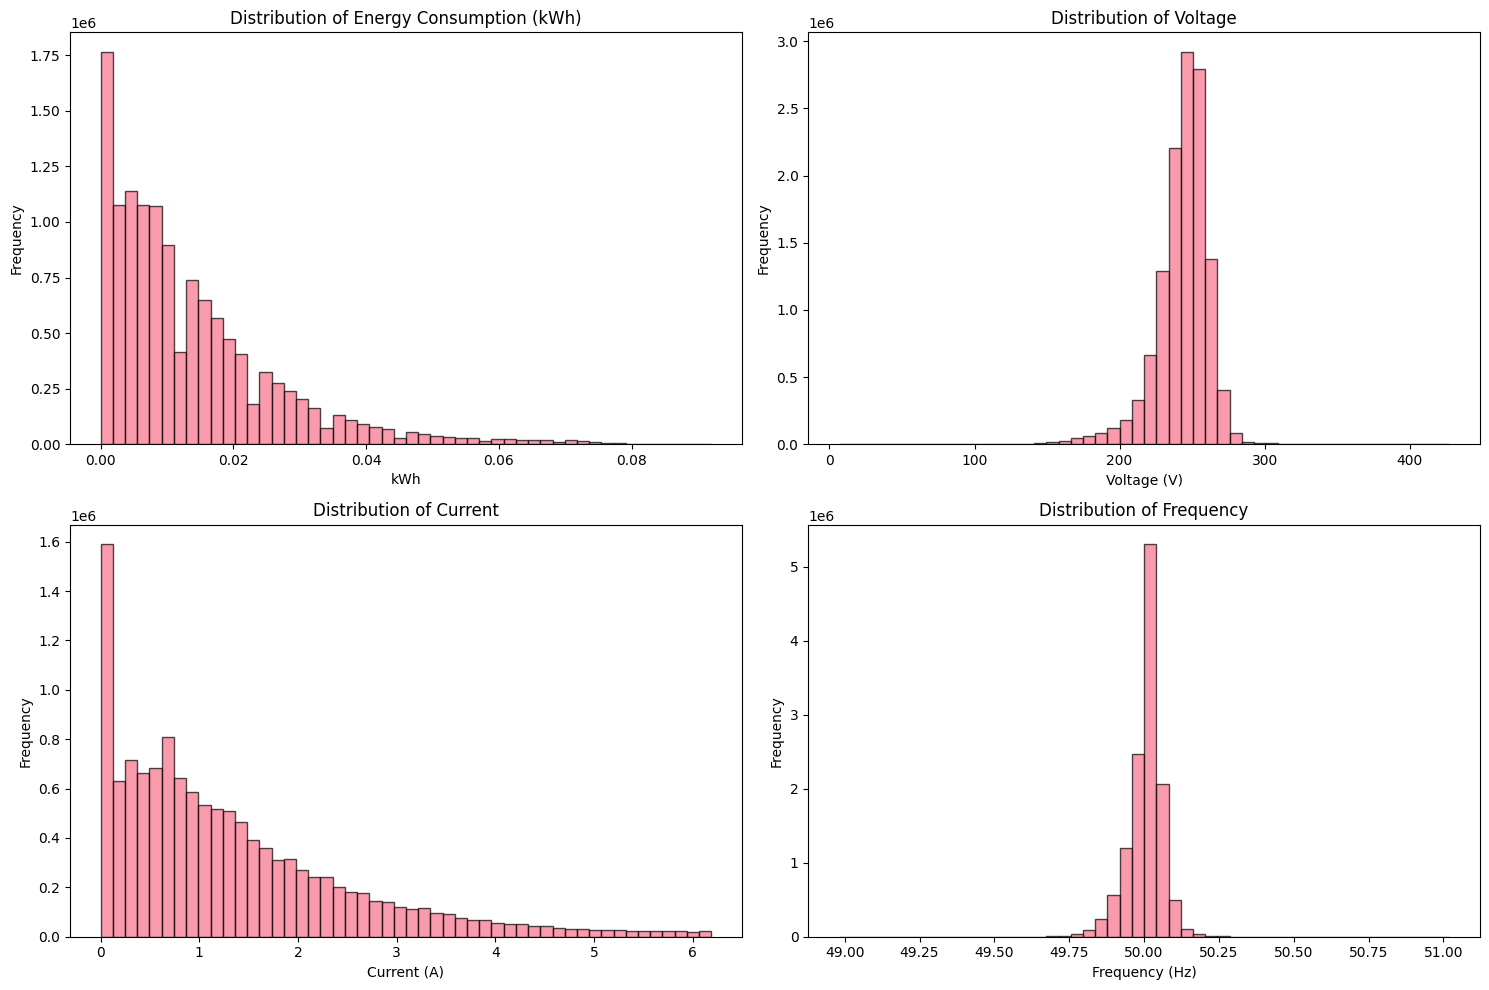

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# kWh distribution
axes[0,0].hist(df_clean['kwh'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution of Energy Consumption (kWh)')
axes[0,0].set_xlabel('kWh')
axes[0,0].set_ylabel('Frequency')

# Voltage distribution
axes[0,1].hist(df_clean['voltage'], bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Distribution of Voltage')
axes[0,1].set_xlabel('Voltage (V)')
axes[0,1].set_ylabel('Frequency')

# Current distribution
axes[1,0].hist(df_clean['current'], bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Distribution of Current')
axes[1,0].set_xlabel('Current (A)')
axes[1,0].set_ylabel('Frequency')

# Frequency distribution
axes[1,1].hist(df_clean['frequency'], bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Distribution of Frequency')
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 13. Advanced Analysis

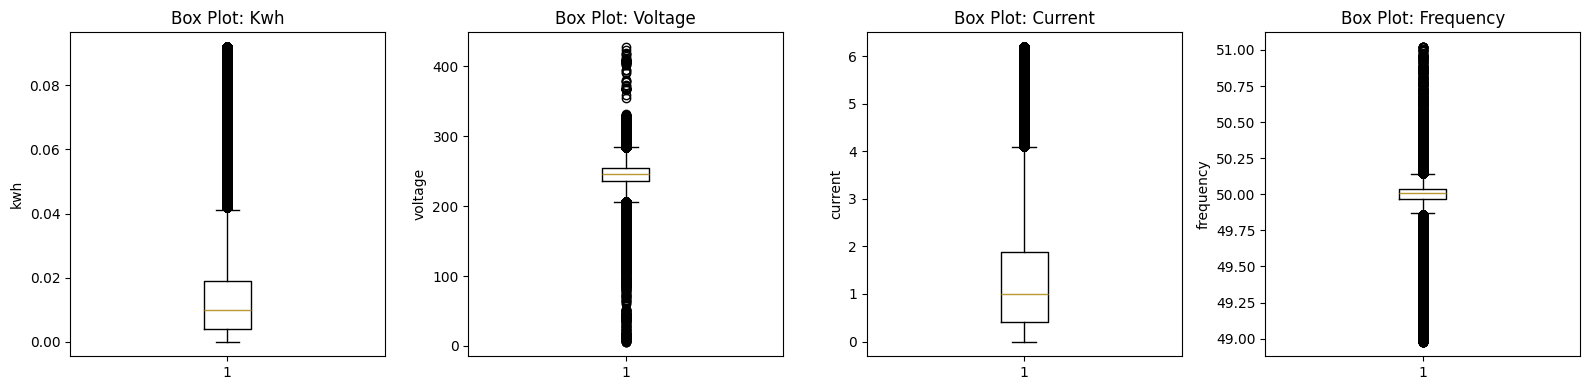

In [31]:
# Box plots for key variables
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

numeric_cols = ['kwh', 'voltage', 'current', 'frequency']
for i, col in enumerate(numeric_cols):
    axes[i].boxplot(df_clean[col])
    axes[i].set_title(f'Box Plot: {col.title()}')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

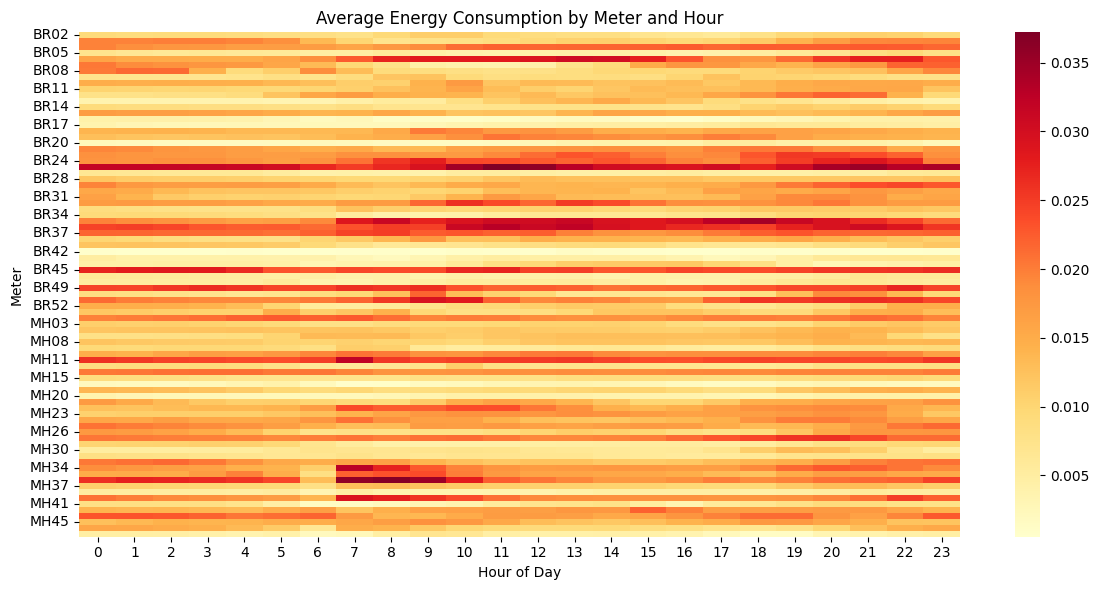

In [32]:
# Energy consumption patterns by meter and hour
pivot_data = df_clean.groupby(['meter', 'hour'])['kwh'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='YlOrRd', annot=False)
plt.title('Average Energy Consumption by Meter and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Meter')
plt.tight_layout()
plt.show()

## 11. Save Cleaned Data and Summary

In [33]:
# Save cleaned dataset
print("=== SAVING CLEANED DATA ===")
df_clean.to_csv('cleaned_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'")

=== SAVING CLEANED DATA ===
Cleaned dataset saved as 'cleaned_dataset.csv'


In [34]:
# Summary report
print("=== SUMMARY REPORT ===")
print(f"Original dataset: {len(df):,} rows")
print(f"Cleaned dataset: {len(df_clean):,} rows")
print(f"Data reduction: {((len(df) - len(df_clean)) / len(df) * 100):.2f}%")
print(f"Date range: {df_clean['timestamp'].min()} to {df_clean['timestamp'].max()}")
print(f"Total energy consumption: {df_clean['kwh'].sum():.2f} kWh")
print(f"Average energy consumption: {df_clean['kwh'].mean():.4f} kWh")
print(f"Number of meters: {df_clean['meter'].nunique()}")

# Create summary dataframe
summary_data = {
    'Metric': ['Original Rows', 'Cleaned Rows', 'Data Reduction %', 'Total kWh', 'Average kWh', 'Unique Meters'],
    'Value': [f"{len(df):,}", f"{len(df_clean):,}", f"{((len(df) - len(df_clean)) / len(df) * 100):.2f}%", 
              f"{df_clean['kwh'].sum():.2f}", f"{df_clean['kwh'].mean():.4f}", df_clean['meter'].nunique()]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)

=== SUMMARY REPORT ===
Original dataset: 14,767,069 rows
Cleaned dataset: 12,648,930 rows
Data reduction: 14.34%
Date range: 2019-05-01 00:00:00 to 2021-10-31 23:57:00
Total energy consumption: 170412.12 kWh
Average energy consumption: 0.0135 kWh
Number of meters: 84


,Metric,Value
0,Original Rows,"14,767,069"
1,Cleaned Rows,"12,648,930"
2,Data Reduction %,14.34%
3,Total kWh,170412.12
4,Average kWh,0.0135
5,Unique Meters,84
